In [1]:
# Imports
from defisheye import Defisheye
from torchvision.datasets import coco
from pathlib import Path
import torch, torchvision
import numpy as np
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader, random_split, Subset
import gc
import torch
from torchvision.ops import box_iou

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Available:", torch.cuda.is_available(), device)
if torch.cuda.is_available():
    print("Current Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated() / 1e6, "MB")


def cleanup_gpu():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
# Clean prior GPU cache in case of previous run memory leaks
cleanup_gpu()


GPU Available: False cpu


/home/torab/Documents/assignments/deeplearning/project/aicitychallenge1/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


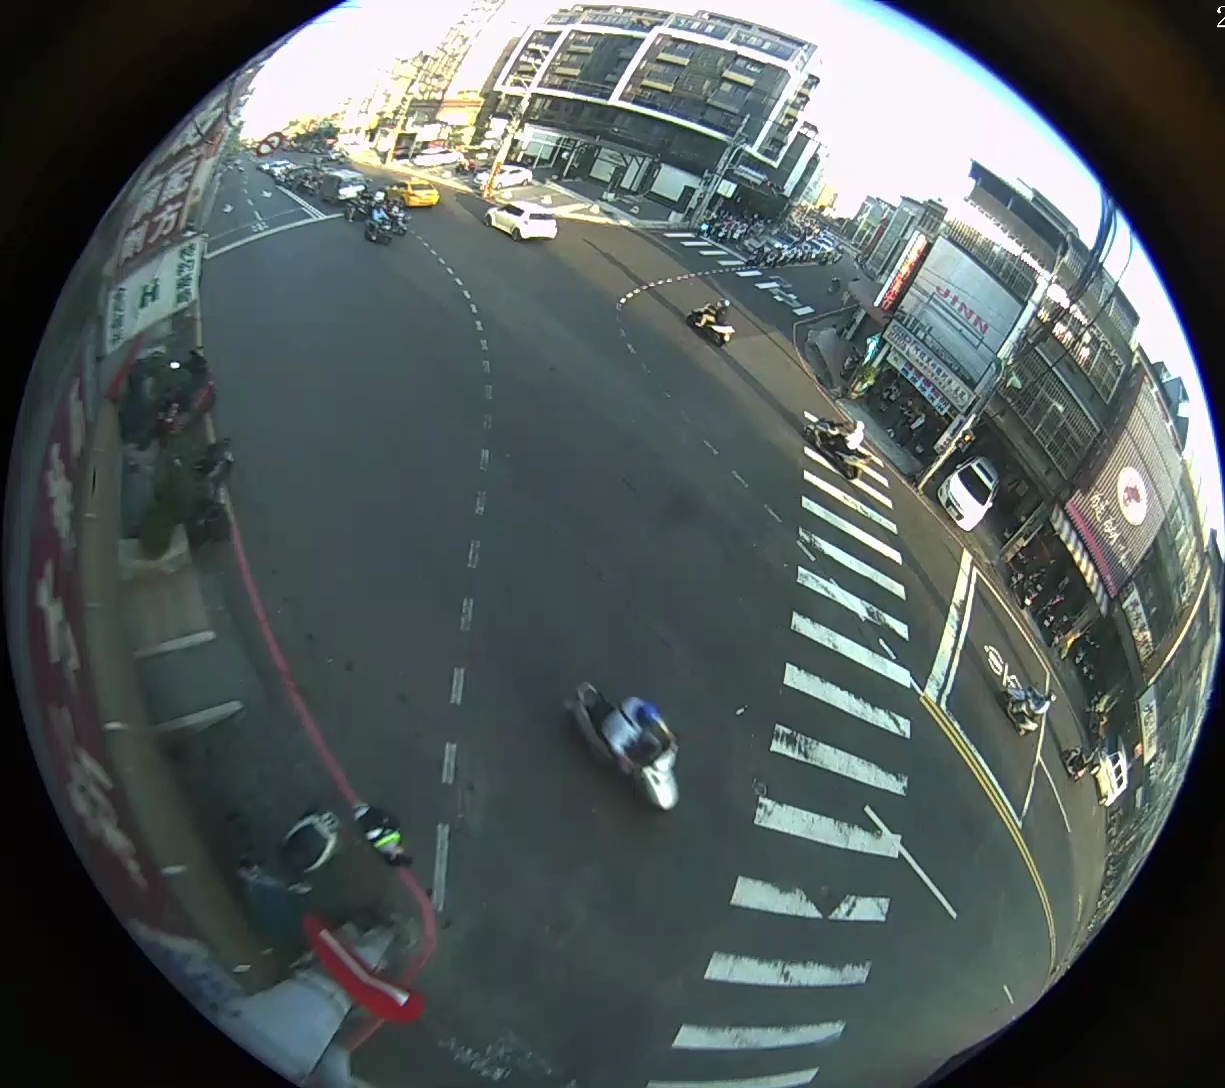

In [2]:
# Display original fisheyes images

img = "camera.png"
img_out = f"normal.png"
og_image = Image.open(img)
display(og_image)
# og_image.show()

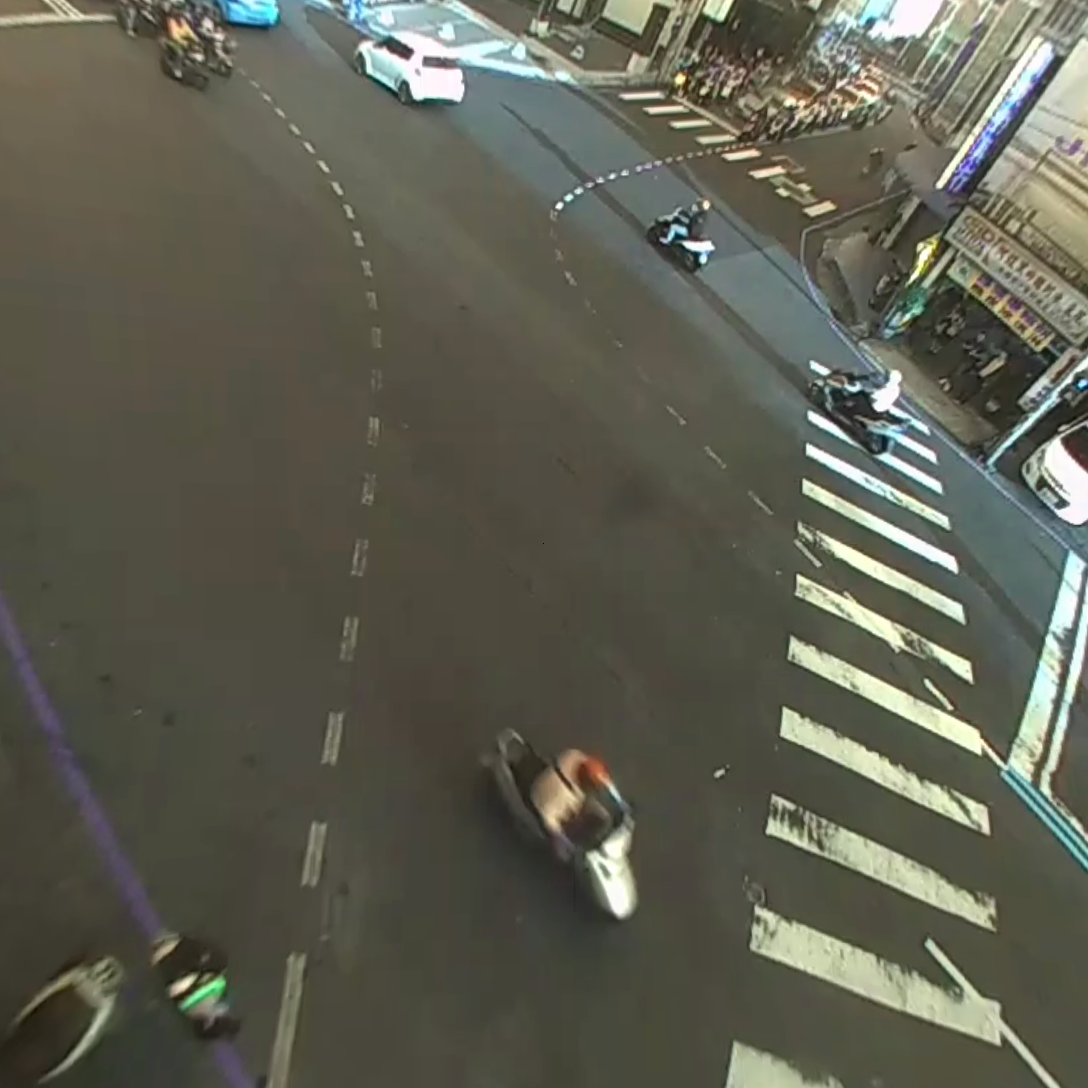

In [3]:
# Defisheye and show the defisheyed images

dtype = 'linear'
format = 'fullframe'
fov = 150
pfov = 90

obj = Defisheye(img, dtype=dtype, format=format, fov=fov, pfov=pfov)

obj.convert(outfile=img_out)

new_image = obj.convert()
image = Image.fromarray(new_image)
display(image)


In [4]:
# This helps in showing images using matplotlib in python notebooks
# matplotlib.use('Agg')
%matplotlib inline 
# total_plots = 3 
# fig, axes = plt.subplots(1, total_plots, figsize=(6 * total_plots, 7))



In [5]:
# Draw bounding box and text for each result
def draw_bounding_box(ax, bounding_box, text, color):
    x1, y1, w, h = bounding_box
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 10, text,
            color=color, fontsize=8, weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))

In [6]:
# For different colors for different classes and the classes we have to detect
colors = [
        "red", "green", "blue", "purple", "orange", "cyan", "magenta", "yellow", "lime", "pink"
    ]
classes = ["Bus", "Bike", "Car", "Pedestrian", "Truck"]


# Draw bounding boxes and classes on yolo results with confidence
def draw_bounding_box_yolo(ax, model_name, result):
    images = []
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    class_ids = result.boxes.cls.cpu().numpy()
    names = result.names 
    ax.imshow(Image.fromarray(result.orig_img))
    ax.set_title(f"{model_name}")
    ax.axis('off')

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        
        score = scores[i]
        class_id = int(class_ids[i])
        class_name = names[class_id]
        color = colors[class_id % len(colors)]
        # draw.rectangle((x1, y1, x2, y2), outline=color)
        text = f"{class_name} {score:.2f}"
        draw_bounding_box(ax, [x1, y1, x2 - x1, y2 - y1], text, color)
        # draw.text((x1, y1 - 10), text, fill=color)
        
        print(f"  Object {i+1}:")
        print(f"    Class: {class_name} (ID: {class_id})")
        print(f"    Confidence: {score:.2f}")
        print(f"    Bounding Box: [x1={x1:.0f}, y1={y1:.0f}, x2={x2:.0f}, y2={y2:.0f}]")
        images.append(ax)
    return images

In [20]:
def greedy_match(pred_boxes, gt_boxes, iou_threshold=0.5):
    # print(f"pred_boxes: {pred_boxes}, gt_boxes: {gt_boxes}")
    matched_gt = set()
    matched_pred = set()
    ious = box_iou(gt_boxes, pred_boxes)

    matches = []
    for gt_idx in range(ious.size(0)):
        iou_row = ious[gt_idx]
        max_iou, pred_idx = torch.max(iou_row, dim=0)

        if max_iou >= iou_threshold and pred_idx.item() not in matched_pred:
            matches.append((gt_idx, pred_idx.item()))
            matched_gt.add(gt_idx)
            matched_pred.add(pred_idx.item())

    return matches, ious

In [8]:
def calculate_baseline_scores(matches, ious, pred_boxes, gt_boxes, iou_threshold):
    total_tp = total_fp = total_fn = 0

    valid_matches = [(gt_idx, pred_idx) for gt_idx, pred_idx in matches if ious[gt_idx, pred_idx] >= iou_threshold]
    tp = len(valid_matches)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    total_tp += tp
    total_fp += fp
    total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1

In [9]:
# Declare dataset paths
dataset_path = Path('data')
train_images, train_ann = f"{dataset_path}/train/images", f"{dataset_path}/train/train.json"
test_images, test_ann = f"{dataset_path}/test/images", f"{dataset_path}/test/test.json"

In [10]:
# Declare datasets using the coco detection class
train_dataset = coco.CocoDetection(train_images, annFile=train_ann)
test_dataset = coco.CocoDetection(test_images, annFile=test_ann)


loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [11]:
# This is to use Dataloader. labels(groundtruth label can be of varying size)
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

In [12]:
# Load a sample batch to perform object detection
SAMPLE_SIZE = 10
sample_loader = DataLoader(train_dataset, batch_size=SAMPLE_SIZE, shuffle=True, collate_fn=collate_fn)
sample_images_pil, sample_labels_gt = next(iter(sample_loader))
# Convert images from PIL to numpy arrays because YOLO sometimes doesn't give results for PIL images. It is build for numpy arrays
sample_images_np = [np.array(img) for img in sample_images_pil]

del sample_images_pil
len(sample_images_np)


10

In [ ]:
# models = [
#     {'name': 'yolov5s', 'obj': YOLO("yolov5s.pt", task='detect').to(device)},
#     {'name': 'yolov8m', 'obj': YOLO("yolov8m.pt", task='detect').to(device)},
#     {'name': 'yolo11m', 'obj': YOLO("yolo11m.pt", task='detect').to(device)},
#     {'name': 'yolov8s', 'obj': YOLO("yolov8s.pt", task='detect').to(device)},
#     {'name': 'yolov8n', 'obj': YOLO("yolov8n.pt", task='detect').to(device)},
#     {'name': 'yolov8l', 'obj': YOLO("yolov8l.pt", task='detect').to(device)},
#     {'name': 'yolov9c', 'obj': YOLO("yolov9c.pt", task='detect').to(device)},
#     {'name': 'yolov10m', 'obj': YOLO("yolov10m.pt", task='detect').to(device)}
# ]

# Add multiple models with their paths to compare output of different models with ground truth
model_paths = {
    'yolov5s': "yolov5s.pt",
    'yolov8m': "yolov8m.pt",
    'yolo11m': "yolo11m.pt",
    'yolov8s': "yolov8s.pt",
    'yolov8n': "yolov8n.pt",
    'yolov8l': "yolov8l.pt",
    'yolov9c': "yolov9c.pt",
    'yolov10m': "yolov10m.pt"
}

# Lazy load models, run the detection and save the results. Deleting model help us in avoiding memory leaks
def load_and_run(model_name, image_batch):
    model = YOLO(model_paths[model_name])
    results = model(image_batch, device=device)

    print(f"{model_name} on device: {model.device}")
    del model
    cleanup_gpu()
    return results

In [14]:
# Perform detection on the entire batch using multiple models
results_list = list()
for model in model_paths.keys():
    results = load_and_run(model, sample_images_np)
    results_list.append({'model_name': model, 'results': results})
    # print(f"{model['name']} inference done. First image shape: {results[0].orig_img.shape}")
    

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 640x640 6 cars, 1 motorcycle, 259.9ms
1: 640x640 (no detections), 259.9ms
2: 640x640 6 cars, 259.9ms
3: 640x640 (no detections), 259.9ms
4: 640x640 2 persons, 259.9ms
5: 640x640 1 car, 1 airplane, 2 boats, 259.9ms
6: 640x640 (no detections), 259.9ms
7: 640x640 1 car, 259.9ms
8: 640x640 (no detections), 259.9ms
9: 640x640 9 cars, 259.9ms
Speed: 9.3ms preprocess, 259.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
yolov5s on device: cpu


In [15]:

# Define total number of plots for each image. len(results_list) for each model and 1 for the ground truth
total_plots = len(results_list) + 1
# Define image grid dimensions
images_per_row = 4
rows = (total_plots + images_per_row - 1) // images_per_row

i: 0
  Object 1:
    Class: car (ID: 2)
    Confidence: 0.66
    Bounding Box: [x1=546, y1=218, x2=656, y2=270]
  Object 2:
    Class: car (ID: 2)
    Confidence: 0.51
    Bounding Box: [x1=352, y1=176, x2=408, y2=211]
  Object 3:
    Class: car (ID: 2)
    Confidence: 0.45
    Bounding Box: [x1=308, y1=167, x2=345, y2=189]
  Object 4:
    Class: motorcycle (ID: 3)
    Confidence: 0.35
    Bounding Box: [x1=468, y1=198, x2=508, y2=244]
  Object 5:
    Class: car (ID: 2)
    Confidence: 0.33
    Bounding Box: [x1=430, y1=147, x2=487, y2=169]
  Object 6:
    Class: car (ID: 2)
    Confidence: 0.32
    Bounding Box: [x1=521, y1=182, x2=600, y2=229]
  Object 7:
    Class: car (ID: 2)
    Confidence: 0.27
    Bounding Box: [x1=702, y1=237, x2=727, y2=260]
model_name: yolov5s, precision: 0.9999998571428775, recall: 0.18918918407596802, f1: 0.3181815361572294


i: 1
Skipping image 1: No GT or predicted boxes.


i: 2
  Object 1:
    Class: car (ID: 2)
    Confidence: 0.92
    Bounding Box: [x1=609, y1=240, x2=1106, y2=502]
  Object 2:
    Class: car (ID: 2)
    Confidence: 0.89
    Bounding Box: [x1=499, y1=86, x2=802, y2=274]
  Object 3:
    Class: car (ID: 2)
    Confidence: 0.72
    Bounding Box: [x1=1653, y1=345, x2=1729, y2=441]
  Object 4:
    Class: car (ID: 2)
    Confidence: 0.71
    Bounding Box: [x1=1511, y1=172, x2=1609, y2=252]
  Object 5:
    Class: car (ID: 2)
    Confidence: 0.51
    Bounding Box: [x1=1636, y1=279, x2=1701, y2=346]
  Object 6:
    Class: car (ID: 2)
    Confidence: 0.42
    Bounding Box: [x1=1416, y1=105, x2=1458, y2=141]
model_name: yolov5s, precision: 0.9999998333333611, recall: 0.24999998958333375, f1: 0.39999965333356713


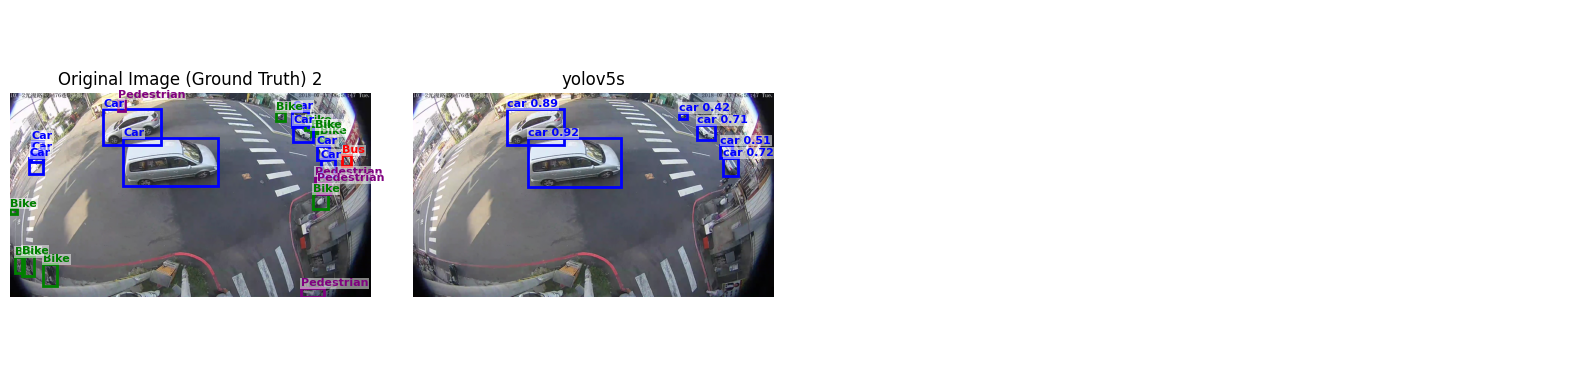

i: 3
Skipping image 3: No GT or predicted boxes.


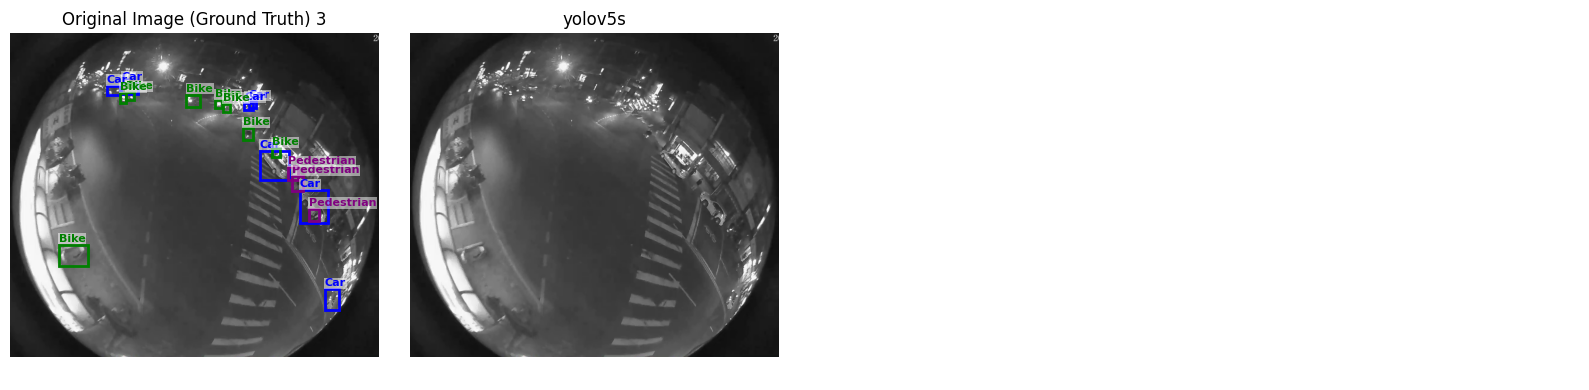

i: 4
  Object 1:
    Class: person (ID: 0)
    Confidence: 0.45
    Bounding Box: [x1=482, y1=209, x2=500, y2=248]
  Object 2:
    Class: person (ID: 0)
    Confidence: 0.28
    Bounding Box: [x1=544, y1=208, x2=569, y2=253]
model_name: yolov5s, precision: 0.499999750000125, recall: 0.03999999840000006, f1: 0.07407393141309507


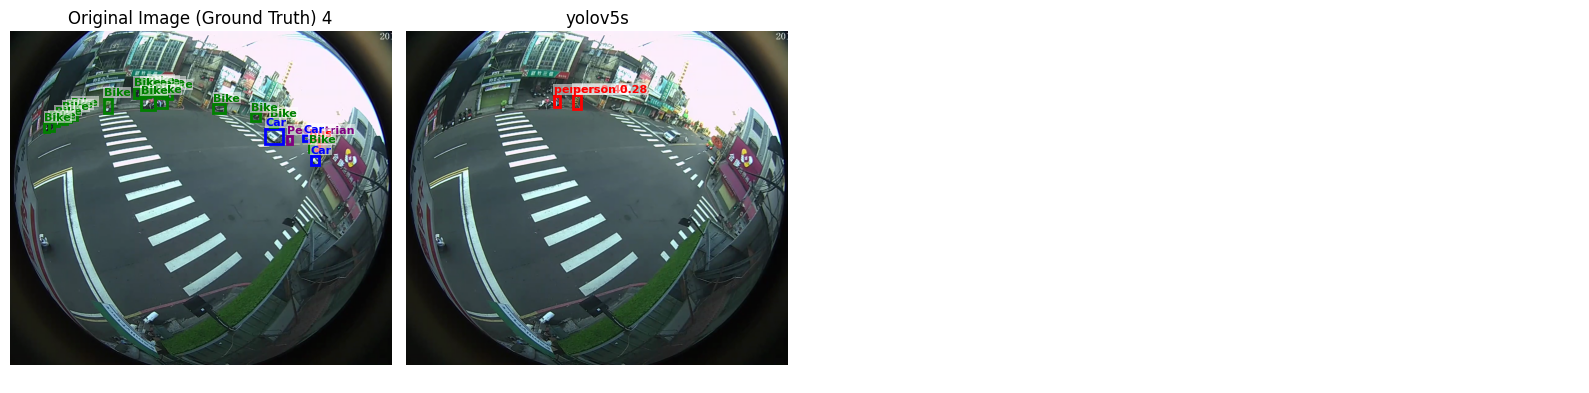

i: 5
  Object 1:
    Class: boat (ID: 8)
    Confidence: 0.66
    Bounding Box: [x1=588, y1=484, x2=947, y2=671]
  Object 2:
    Class: car (ID: 2)
    Confidence: 0.57
    Bounding Box: [x1=264, y1=149, x2=854, y2=453]
  Object 3:
    Class: boat (ID: 8)
    Confidence: 0.49
    Bounding Box: [x1=7, y1=692, x2=1885, y2=1920]
  Object 4:
    Class: airplane (ID: 4)
    Confidence: 0.30
    Bounding Box: [x1=0, y1=694, x2=1904, y2=1918]
model_name: yolov5s, precision: 0.49999987500003124, recall: 0.057142855510204135, f1: 0.10256391321528843


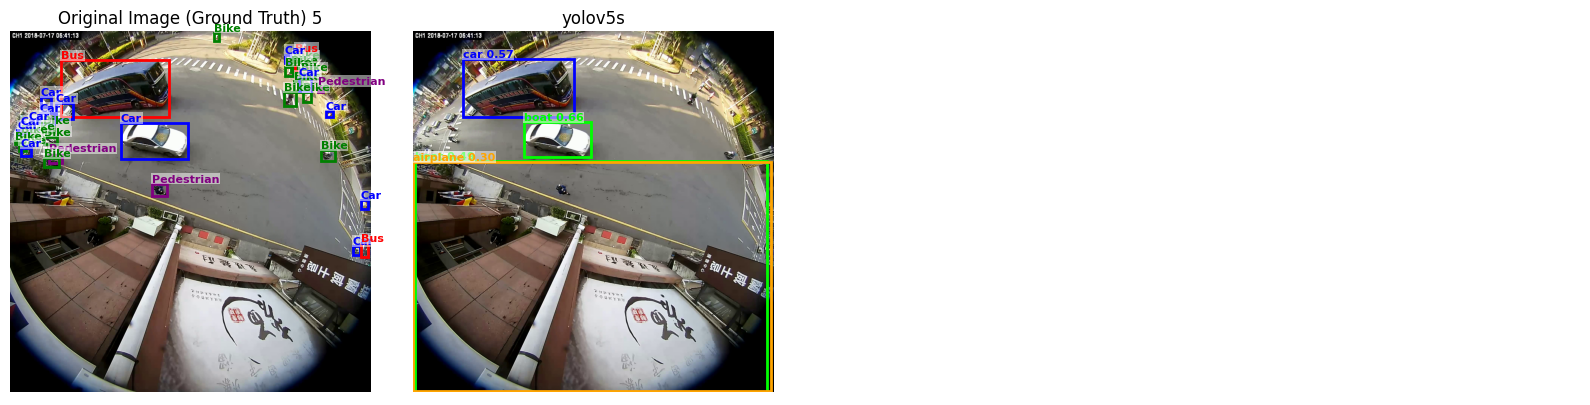

i: 6
Skipping image 6: No GT or predicted boxes.


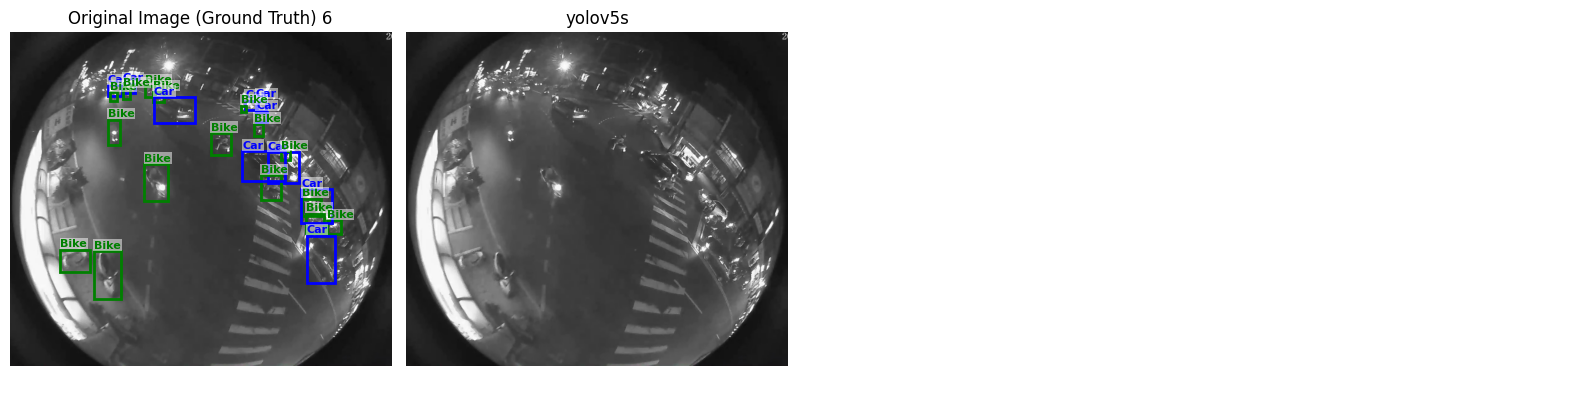

i: 7
  Object 1:
    Class: car (ID: 2)
    Confidence: 0.75
    Bounding Box: [x1=618, y1=301, x2=782, y2=419]
model_name: yolov5s, precision: 0.9999990000010001, recall: 0.07142856632653098, f1: 0.1333331911111295


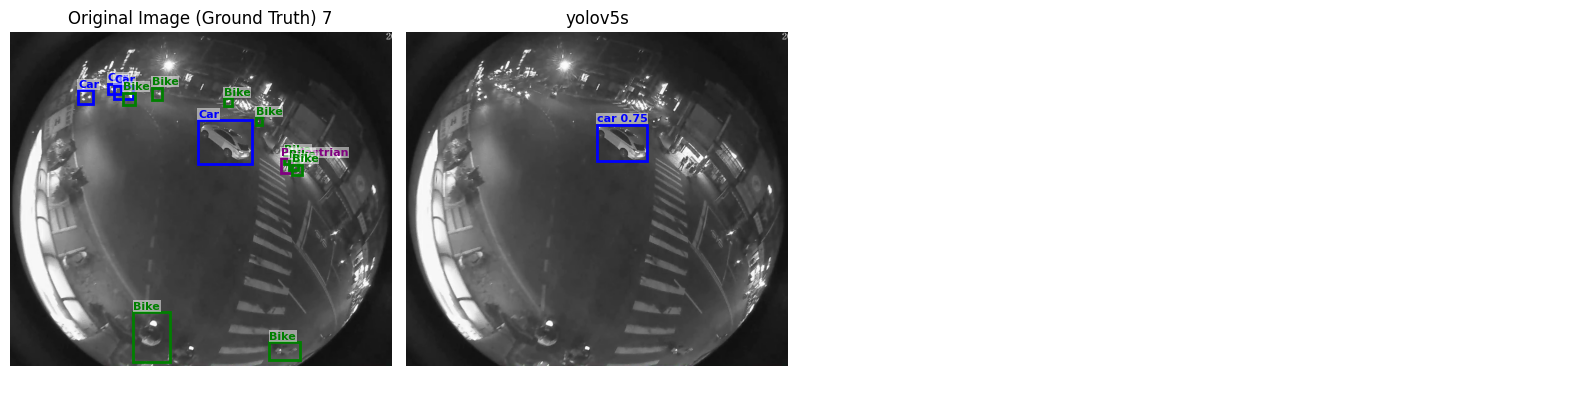

i: 8
Skipping image 8: No GT or predicted boxes.


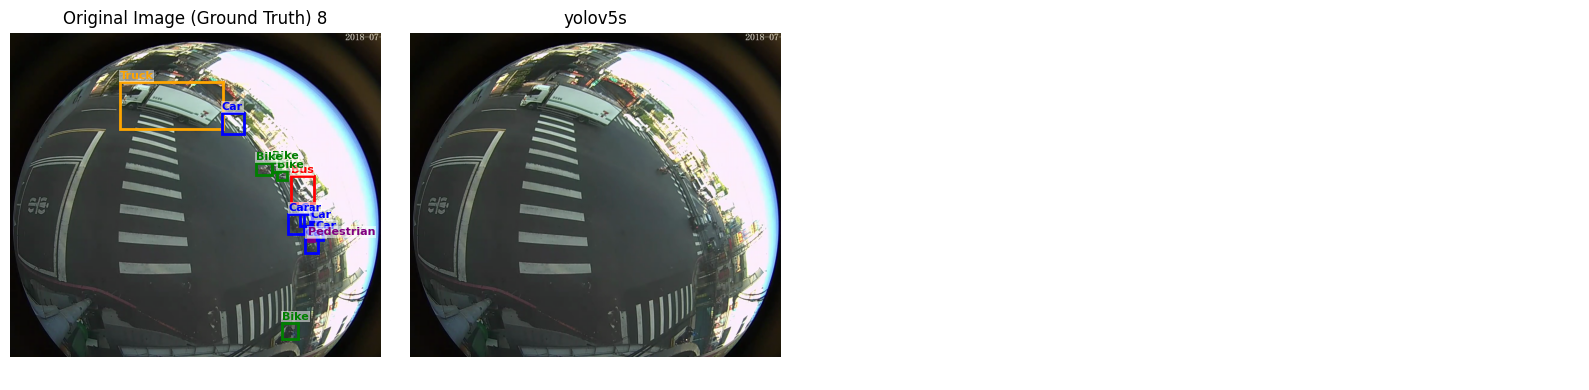

i: 9
  Object 1:
    Class: car (ID: 2)
    Confidence: 0.52
    Bounding Box: [x1=776, y1=323, x2=878, y2=408]
  Object 2:
    Class: car (ID: 2)
    Confidence: 0.44
    Bounding Box: [x1=420, y1=188, x2=488, y2=223]
  Object 3:
    Class: car (ID: 2)
    Confidence: 0.37
    Bounding Box: [x1=369, y1=145, x2=404, y2=164]
  Object 4:
    Class: car (ID: 2)
    Confidence: 0.36
    Bounding Box: [x1=264, y1=200, x2=295, y2=229]
  Object 5:
    Class: car (ID: 2)
    Confidence: 0.34
    Bounding Box: [x1=365, y1=200, x2=404, y2=227]
  Object 6:
    Class: car (ID: 2)
    Confidence: 0.31
    Bounding Box: [x1=429, y1=147, x2=489, y2=170]
  Object 7:
    Class: car (ID: 2)
    Confidence: 0.30
    Bounding Box: [x1=694, y1=334, x2=746, y2=369]
  Object 8:
    Class: car (ID: 2)
    Confidence: 0.26
    Bounding Box: [x1=508, y1=163, x2=555, y2=193]
  Object 9:
    Class: car (ID: 2)
    Confidence: 0.25
    Bounding Box: [x1=340, y1=183, x2=388, y2=214]
model_name: yolov5s, precision: 

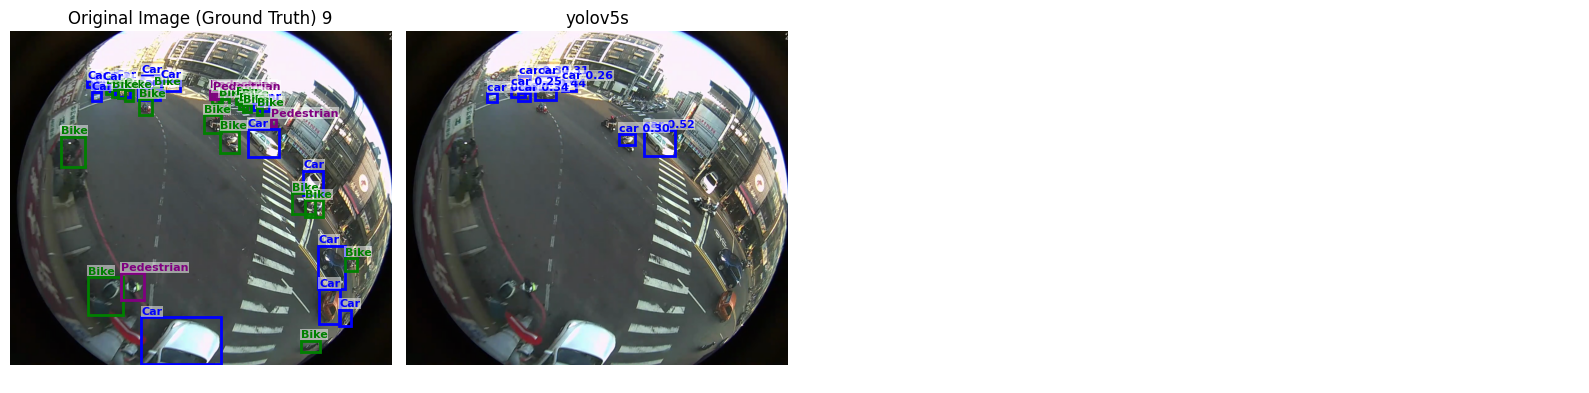

In [21]:
IOU_THRESHOLD = 0.3
# Go through each image
for i, image in enumerate(sample_images_np):
    print(f"i: {i}")
    # Declare a new grid for each image
    fig, axes = plt.subplots(rows, images_per_row, figsize=(4 * images_per_row, 4 * rows))
    flat_axes = axes.flatten()
    # Set ground truth image as the first one
    flat_axes[0].imshow(image)
    flat_axes[0].set_title(f"Original Image (Ground Truth) {i}")
    flat_axes[0].axis('off')
    gt_bboxes = [
        [x, y, x + w, y + h]
        for x, y, w, h in [label['bbox'] for label in sample_labels_gt[i]]
    ]

    gt_tensor = torch.tensor(gt_bboxes, dtype=torch.float32, device=device)
    # Go through ground truth bounding boxes and draw each one on the first image
    
    for label in sample_labels_gt[i]:
        # print(f"label: {label}")
        bbox = label['bbox']

        class_name = classes[label['category_id']]
        color = colors[label['category_id'] % len(colors)]
        text = f"{class_name}"
        draw_bounding_box(flat_axes[0], bbox, text, color)
    
    # Go through results of every model
    for j, model_result in enumerate(results_list):
        # print(f'j: {j}, model: {model_result}')
        # Pick model_name and result for that particular image(ith image) for the model
        model_name = model_result['model_name']
        result = model_result['results'][i] 
        draw_bounding_box_yolo(ax=flat_axes[j+1], model_name=model_name, result=result)
        pred_tensor = torch.tensor(result.boxes.xyxy.cpu().numpy(), dtype=torch.float32, device=device)
        # print(f"first_result: {result.boxes.xyxy.cpu().numpy()} \n gt_bboxes: {gt_bboxes} \n gt_bboxes: {gt_bboxes}" )
        if gt_tensor.numel() == 0 or pred_tensor.numel() == 0:
            print(f"Skipping image {i}: No GT or predicted boxes.")
            continue

        matches, ious = greedy_match(pred_boxes = pred_tensor, gt_boxes=gt_tensor, iou_threshold=IOU_THRESHOLD)
        precision, recall, f1 = calculate_baseline_scores(matches=matches, ious=ious, pred_boxes= pred_tensor, gt_boxes=gt_bboxes, iou_threshold=IOU_THRESHOLD)
        # print(f"matches: {matches}, ious: {ious}")
        print(f"model_name: {model_name}, precision: {precision}, recall: {recall}, f1: {f1}")

    # Disable the empty plots since we might not able to fill the last row
    for plot in range(total_plots, len(flat_axes)):
        flat_axes[plot].axis('off')
    # Display the plot and close the fig to free memory
    plt.tight_layout()
    display(fig)
    plt.close(fig)


In [17]:
# One final clean up
cleanup_gpu()

In [ ]:
# # print(f"results_list: {results_list}")

# first_result = results_list[0]['results'][0]
# first_gt = sample_labels_gt[0]
# gt_bboxes = [
#     [x, y, x + w, y + h]
#     for x, y, w, h in [gt['bbox'] for gt in first_gt]
# ]
# gt_tensor = torch.tensor(gt_bboxes, dtype=torch.float32,  device=device)

# pred_tensor = torch.tensor(first_result.boxes.xyxy.cpu().numpy(), dtype=torch.float32, device=device)
# print(f"first_result: {first_result.boxes.xyxy.cpu().numpy()} \n first_gt: {first_gt} \n gt_bboxes: {gt_bboxes}" )

# matches, ious = greedy_match(pred_boxes = pred_tensor, gt_boxes=gt_tensor, iou_threshold=0.3)
# print(f"matches: {matches}, ious: {ious}")

first_result: [[     546.45      218.02      655.68      270.29]
 [     352.42      176.28      408.27       211.4]
 [     308.35      167.13       344.6      189.11]
 [     468.39      198.04      507.63      244.35]
 [     429.64      146.93      487.33      168.92]
 [     521.33       182.1      599.89      228.94]
 [     701.73       237.1      726.55      259.83]] 
 first_gt: [{'id': 101706, 'image_id': 31266, 'category_id': 1, 'bbox': [678, 214, 29, 30], 'area': 870, 'iscrowd': 0}, {'id': 101707, 'image_id': 31266, 'category_id': 1, 'bbox': [705, 237, 19, 26], 'area': 494, 'iscrowd': 0}, {'id': 101708, 'image_id': 31266, 'category_id': 1, 'bbox': [723, 230, 22, 28], 'area': 616, 'iscrowd': 0}, {'id': 101709, 'image_id': 31266, 'category_id': 1, 'bbox': [745, 228, 18, 24], 'area': 432, 'iscrowd': 0}, {'id': 101710, 'image_id': 31266, 'category_id': 1, 'bbox': [161, 342, 86, 98], 'area': 8428, 'iscrowd': 0}, {'id': 101711, 'image_id': 31266, 'category_id': 1, 'bbox': [245, 802, 125